## Домашнее Задание по Теории Графов № 1
#### Стоева Валерия, 154 группа

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 

Все схемы метро я брала с репозитория https://github.com/tupinek?tab=repositories 

   Так как я использую nx.Graph(), то мультиребер в нем нет. Также в наших схемах нет изолированных вершин, так как никому не нужна станция, с которой нельзя никуда уехать.
    
   Значит нам осталось только соединить вершины станций, которые соединены меджу собой переходами

In [2]:
def parse_and_preprocess_graph(xmlfile):
    G = nx.Graph()
    parsed_xml = ET.parse(xmlfile)

    # adding vertices
    for entity in parsed_xml.iter():
        items_dict = dict(entity.items())
        if entity.tag == 'station':
            G.add_node(items_dict['id'] , attrs=items_dict)

    # adding edges
    for entity in parsed_xml.iter():
        items_dict = dict(entity.items())
        if entity.tag == 'station':
            for neighbour in items_dict['link'].split(','):
                G.add_edge(items_dict['id'] , neighbour)
    
    # combine connected stations
    G_old = G.copy()
    for node, spec in G_old.nodes.items():
        if node in G.nodes and 'other_link' in spec['attrs']:
            connected = (node,) + tuple(
                map(
                    lambda connection: connection.split(':')[1],
                    spec['attrs']['other_link'].split(',')
                )
            )
            new_node = '+'.join(connected)
            G.add_node(new_node)
            edges_to_add = [] # handling "RuntimeError: dictionary changed size during iteration"
            for v1, v2 in G.edges:
                if v1 in connected:
                    edges_to_add.append((new_node, v2))
                elif v2 in connected:
                    edges_to_add.append((v1, new_node))
            for e in edges_to_add:
                G.add_edge(*e)
            for v in connected:
                G.remove_node(v)
    return G

In [84]:
def draw_graph(G, extra_options={}):
    options = {
        'node_color': 'black',
        'node_size': 10,
        'line_color': 'grey',
        'width': 0.3,
        'with_labels': True,
        'font_size': 10,
    }
    options.update(extra_options)
    plt.figure(3,figsize=(12,12)) 
    nx.draw(G,pos=nx.spring_layout(G),  **options)

Для анализа было выбрано 3 смемы метро: 

    1) Петербу́ргский метрополите́н: 5 линий, 69 станций
    2) Ки́евский метрополите́н: 3 линии, 52 станции
    3) Метрополите́н Тбилиси: 2 линия, 20 станций
    
Считываем и обрабатываем графы и выводим их схемы на экран

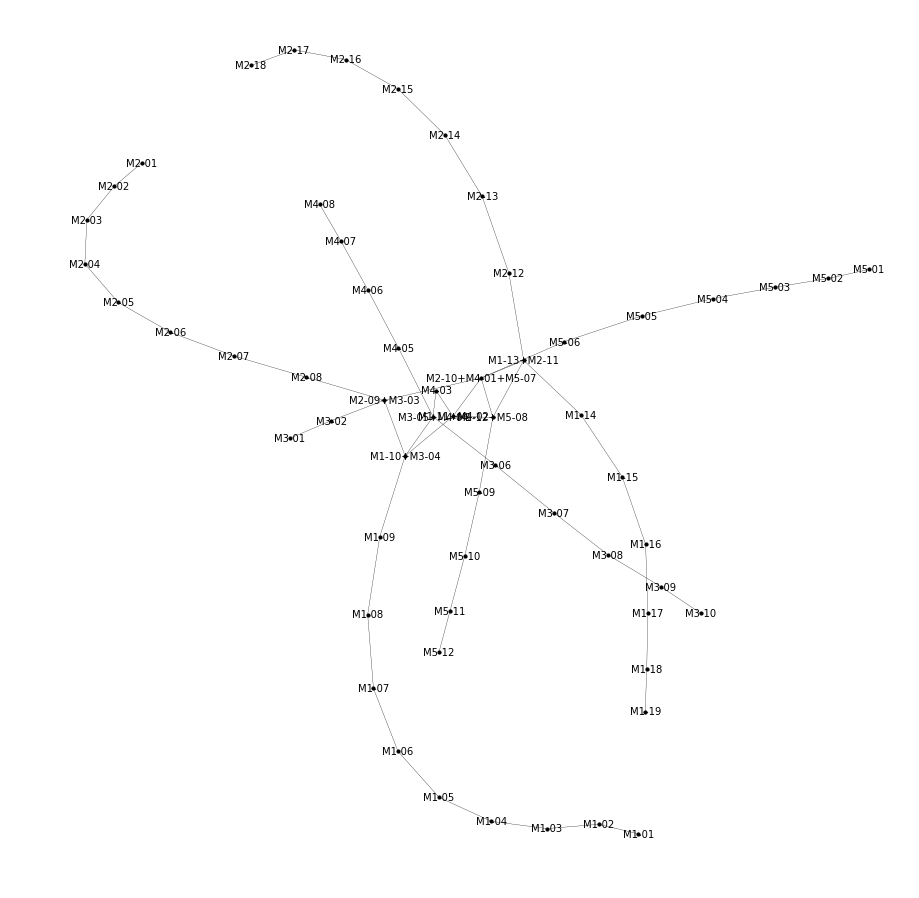

In [93]:
SP = parse_and_preprocess_graph('saint_petersburg-map.xml')
draw_graph(SP)

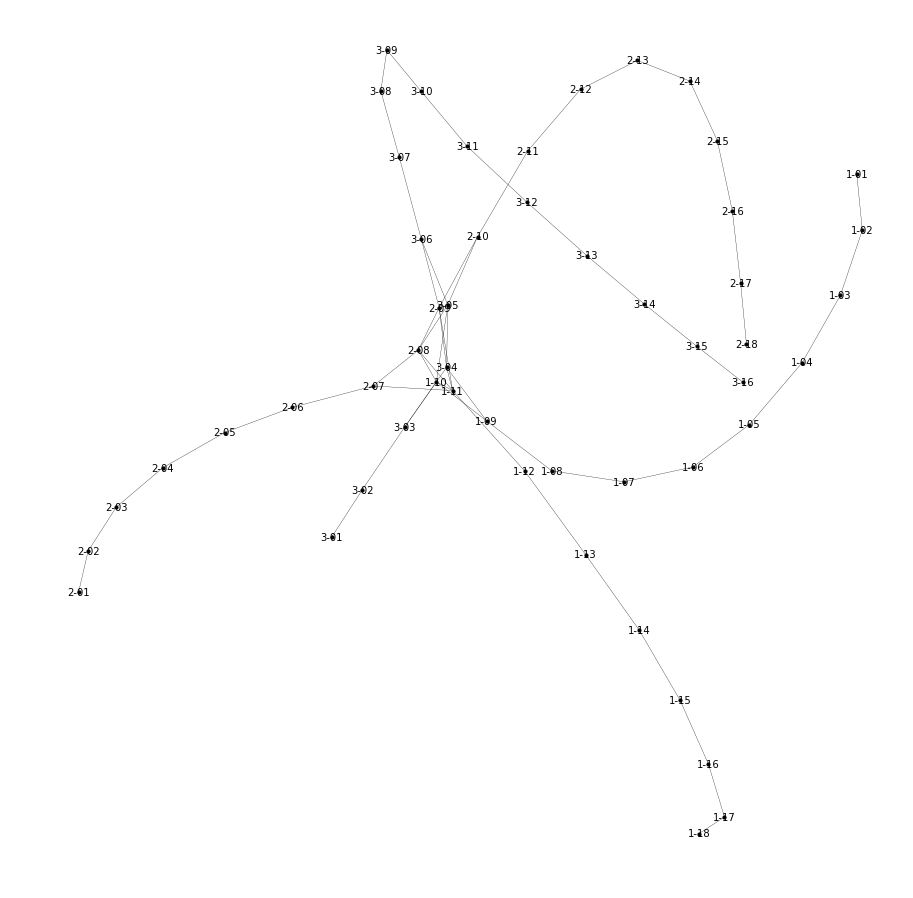

In [94]:
Kiev = parse_and_preprocess_graph('kiev-map.xml')
draw_graph(Kiev)

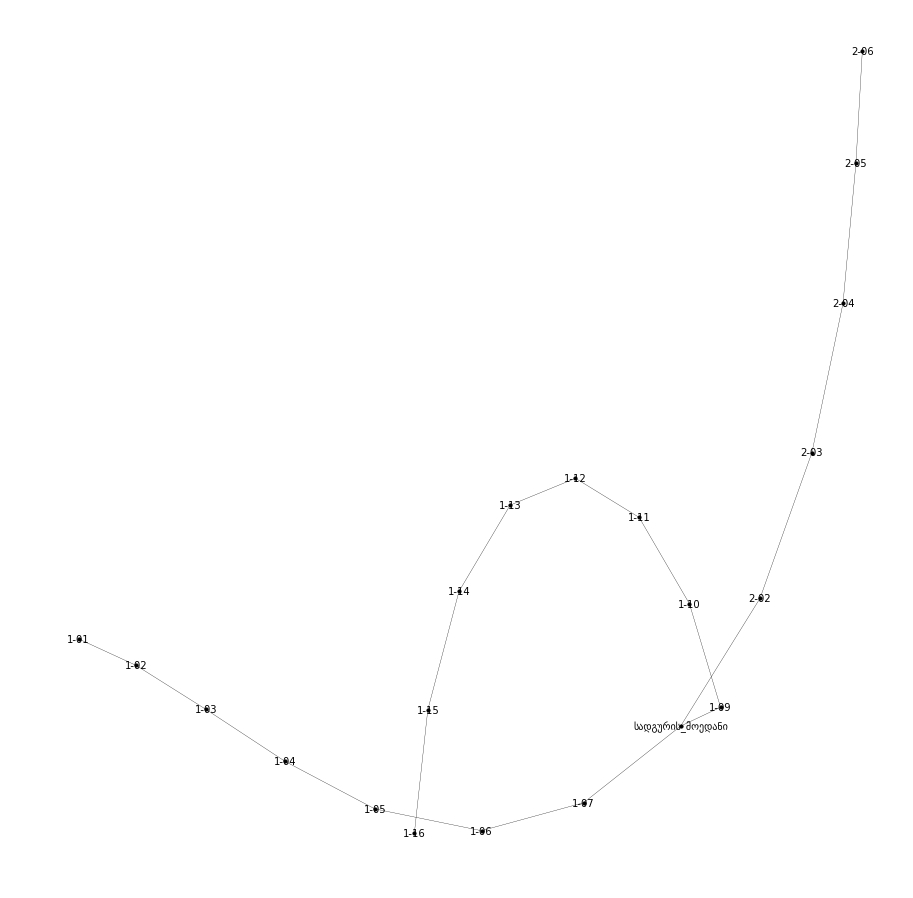

In [95]:
Tbilisi = parse_and_preprocess_graph('tbilisi-map.xml')
draw_graph(Tbilisi)

### 3. Проверка на изоморфность алгоритмом VF2
Проверим на изоморфность Метро Питера и Киева методом VF2, реализованном в networkx.algorithms 

In [96]:
from networkx.algorithms import isomorphism
SP_Kiev = isomorphism.GraphMatcher(SP, Kiev)
SP_Kiev.is_isomorphic()

False

### Проверка на изоморфность алгоритмом BLISS
Проверим на изоморфность Метро Питера и Киева методом  BLISS, реализованном в igraph. 
ДЛя этого сначала приведем наши графы к подходящему виду, то есть из networkx в igraph

In [97]:
import igraph as ig
g1 = ig.Graph.Adjacency((nx.to_numpy_matrix(Kiev) > 0).tolist())
g2 = ig.Graph.Adjacency((nx.to_numpy_matrix(SP) > 0).tolist())
g1.isomorphic_bliss(g2)

False

Как мы видим, обо метода дают один и тот же результат

### 4. В большом графе указать какой-либо подграф, изоморфный маленькому
Проверяем подрграфы Питерского метро на изоморфность с Екатеринбургским метрополитеном

In [98]:
ism = isomorphism.GraphMatcher(Kiev, Tbilisi)
for subgraph in ism.subgraph_isomorphisms_iter():
    print(subgraph)

{'1-10': 'სადგურის_მოედანი', '1-09': '1-07', '1-08': '1-06', '1-07': '1-05', '1-06': '1-04', '1-05': '1-03', '1-04': '1-02', '1-03': '1-01', '3-05': '1-09', '2-10': '1-10', '2-11': '1-11', '2-12': '1-12', '2-13': '1-13', '2-14': '1-14', '2-15': '1-15', '2-16': '1-16', '1-11': '2-02', '2-07': '2-03', '2-06': '2-04', '2-05': '2-05', '2-04': '2-06'}
{'1-10': 'სადგურის_მოედანი', '1-09': '1-07', '1-08': '1-06', '1-07': '1-05', '1-06': '1-04', '1-05': '1-03', '1-04': '1-02', '1-03': '1-01', '3-05': '1-09', '2-10': '1-10', '2-11': '1-11', '2-12': '1-12', '2-13': '1-13', '2-14': '1-14', '2-15': '1-15', '2-16': '1-16', '1-11': '2-02', '1-12': '2-03', '1-13': '2-04', '1-14': '2-05', '1-15': '2-06'}
{'1-10': 'სადგურის_მოედანი', '1-09': '1-07', '1-08': '1-06', '1-07': '1-05', '1-06': '1-04', '1-05': '1-03', '1-04': '1-02', '1-03': '1-01', '3-05': '1-09', '3-06': '1-10', '3-07': '1-11', '3-08': '1-12', '3-09': '1-13', '3-10': '1-14', '3-11': '1-15', '3-12': '1-16', '1-11': '2-02', '2-07': '2-03', '

{'2-08': 'სადგურის_მოედანი', '1-10': '1-07', '1-09': '1-06', '1-08': '1-05', '1-07': '1-04', '1-06': '1-03', '1-05': '1-02', '1-04': '1-01', '2-09': '1-09', '2-10': '1-10', '2-11': '1-11', '2-12': '1-12', '2-13': '1-13', '2-14': '1-14', '2-15': '1-15', '2-16': '1-16', '2-07': '2-02', '2-06': '2-03', '2-05': '2-04', '2-04': '2-05', '2-03': '2-06'}
{'2-08': 'სადგურის_მოედანი', '1-10': '1-07', '1-09': '1-06', '1-08': '1-05', '1-07': '1-04', '1-06': '1-03', '1-05': '1-02', '1-04': '1-01', '2-09': '1-09', '3-06': '1-10', '3-07': '1-11', '3-08': '1-12', '3-09': '1-13', '3-10': '1-14', '3-11': '1-15', '3-12': '1-16', '2-07': '2-02', '2-06': '2-03', '2-05': '2-04', '2-04': '2-05', '2-03': '2-06'}
{'2-09': 'სადგურის_მოედანი', '2-08': '1-07', '2-07': '1-06', '2-06': '1-05', '2-05': '1-04', '2-04': '1-03', '2-03': '1-02', '2-02': '1-01', '2-10': '1-09', '2-11': '1-10', '2-12': '1-11', '2-13': '1-12', '2-14': '1-13', '2-15': '1-14', '2-16': '1-15', '2-17': '1-16', '3-06': '2-02', '3-07': '2-03', '

{'3-04': 'სადგურის_მოედანი', '3-05': '1-07', '2-10': '1-06', '2-11': '1-05', '2-12': '1-04', '2-13': '1-03', '2-14': '1-02', '2-15': '1-01', '1-11': '1-09', '2-07': '1-10', '2-06': '1-11', '2-05': '1-12', '2-04': '1-13', '2-03': '1-14', '2-02': '1-15', '2-01': '1-16', '1-09': '2-02', '1-08': '2-03', '1-07': '2-04', '1-06': '2-05', '1-05': '2-06'}
{'3-04': 'სადგურის_მოედანი', '3-05': '1-07', '2-10': '1-06', '2-11': '1-05', '2-12': '1-04', '2-13': '1-03', '2-14': '1-02', '2-15': '1-01', '1-11': '1-09', '1-12': '1-10', '1-13': '1-11', '1-14': '1-12', '1-15': '1-13', '1-16': '1-14', '1-17': '1-15', '1-18': '1-16', '1-09': '2-02', '1-08': '2-03', '1-07': '2-04', '1-06': '2-05', '1-05': '2-06'}
{'3-04': 'სადგურის_მოედანი', '3-05': '1-07', '3-06': '1-06', '3-07': '1-05', '3-08': '1-04', '3-09': '1-03', '3-10': '1-02', '3-11': '1-01', '1-09': '1-09', '1-08': '1-10', '1-07': '1-11', '1-06': '1-12', '1-05': '1-13', '1-04': '1-14', '1-03': '1-15', '1-02': '1-16', '1-11': '2-02', '2-07': '2-03', '

Укажем явно один из подграфов

In [99]:
for elem in subgraph:
    print(subgraph[elem] , ':', elem)

სადგურის_მოედანი : 3-05
1-07 : 3-04
1-06 : 1-11
1-05 : 1-12
1-04 : 1-13
1-03 : 1-14
1-02 : 1-15
1-01 : 1-16
1-09 : 3-06
1-10 : 3-07
1-11 : 3-08
1-12 : 3-09
1-13 : 3-10
1-14 : 3-11
1-15 : 3-12
1-16 : 3-13
2-02 : 2-10
2-03 : 2-11
2-04 : 2-12
2-05 : 2-13
2-06 : 2-14


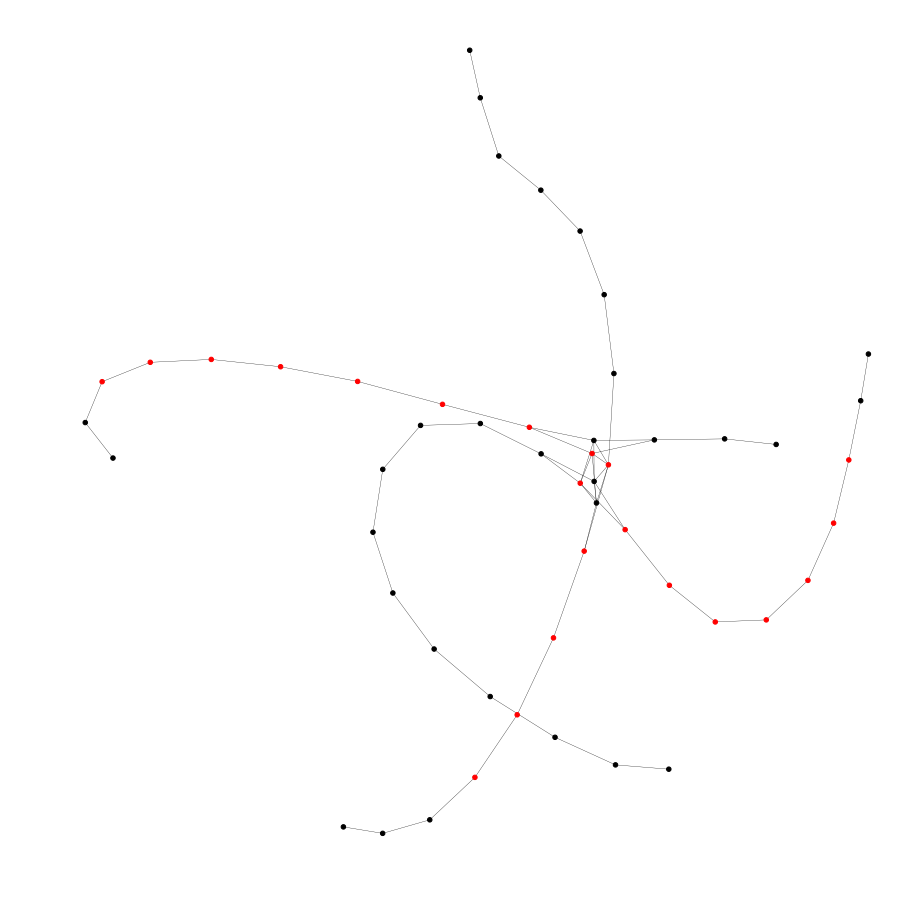

In [100]:
def draw_isomorphic_subgraph(big_graph, small_graph):
    GM = isomorphism.GraphMatcher(big_graph, small_graph)
    sample_iso = next(GM.subgraph_isomorphisms_iter())
    iso_nodes = set(sample_iso.keys())
    colors = ['red' if node in iso_nodes else 'black' for node in big_graph.nodes.keys()]
    draw_graph(
        big_graph,
        {
            'node_color': colors,
            'with_labels': False,
            'node_size': 20,
        }
    )

draw_isomorphic_subgraph(Kiev, Tbilisi)